# ReproductionExperiment_CaliforniaSmoking
- This note is an attempt to reproduce the original paper. 
- Documentation will be added later.
- Original paper : 
Arkhangelsky, Dmitry, et al. Synthetic difference in differences. No. w25532. National Bureau of Economic Research, 2019. https://www.nber.org/papers/w25532
- Reference slide: 
David Hirshberg (Stanford Univ.) "Synthetic difference in differences"
https://davidahirshberg.bitbucket.io/static/synth-did-slides.pdf

In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys
import os

sys.path.append(os.path.abspath("../"))

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
plt.style.use('ggplot')

from tqdm import tqdm

from synthdid.model import SynthDID
from synthdid.sample_data import fetch_CaliforniaSmoking

In [2]:
df = fetch_CaliforniaSmoking()

PRE_TEREM = [1970, 1988]
POST_TEREM = [1989, 2000]

TREATMENT = ["California"]

df.head()

,Alabama,Arkansas,Colorado,Connecticut,Delaware,Georgia,Idaho,Illinois,Indiana,Iowa,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,West Virginia,Wisconsin,Wyoming,California
1970,89.800003,100.300003,124.800003,120.000000,155.000000,109.900002,102.400002,124.800003,134.600006,108.500000,...,92.699997,99.800003,106.400002,65.500000,122.599998,124.300003,114.500000,106.400002,132.199997,123.000000
1971,95.400002,104.099998,125.500000,117.599998,161.100006,115.699997,108.500000,125.599998,139.300003,108.400002,...,96.699997,106.300003,108.900002,67.699997,124.400002,128.399994,111.500000,105.400002,131.699997,121.000000
1972,101.099998,103.900002,134.300003,110.800003,156.300003,117.000000,126.099998,126.599998,149.199997,109.400002,...,103.000000,111.500000,108.599998,71.300003,138.000000,137.000000,117.500000,108.800003,140.000000,123.500000
1973,102.900002,108.000000,137.899994,109.300003,154.699997,119.800003,121.800003,124.400002,156.000000,110.599998,...,103.500000,109.699997,110.400002,72.699997,146.800003,143.100006,116.599998,109.500000,141.199997,124.400002
1974,108.199997,109.699997,132.800003,112.400002,151.300003,123.699997,125.599998,131.899994,159.600006,116.099998,...,108.400002,114.800003,114.699997,75.599998,151.800003,149.600006,119.900002,111.800003,145.800003,126.699997


In [3]:
melt_df = pd.melt(
    df.reset_index().rename(columns={"index": "year"}),
    id_vars="year",
    value_name="consumption",
    var_name="state",
)
melt_df["is_California"] = melt_df["state"] == "California"
melt_df

,year,state,consumption,is_California
0,1970,Alabama,89.800003,False
1,1971,Alabama,95.400002,False
2,1972,Alabama,101.099998,False
3,1973,Alabama,102.900002,False
4,1974,Alabama,108.199997,False
...,...,...,...,...
1204,1996,California,54.500000,True
1205,1997,California,53.799999,True
1206,1998,California,52.299999,True
1207,1999,California,47.200001,True


- As you can see from the chart below, `the parallel trend assumption` required by DID does not hold.
- The usual solution is to use `Synthetic Control Methods`, but in this case we will use `Synthetic Difference in Differences`.
- This data set is a very famous data set for Synthetic Control Methods. For a more detailed explanation, please refer to the following excellent article

 (see) [15 - Synthetic Control](https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html) in "Causal Inference for The Brave and True."

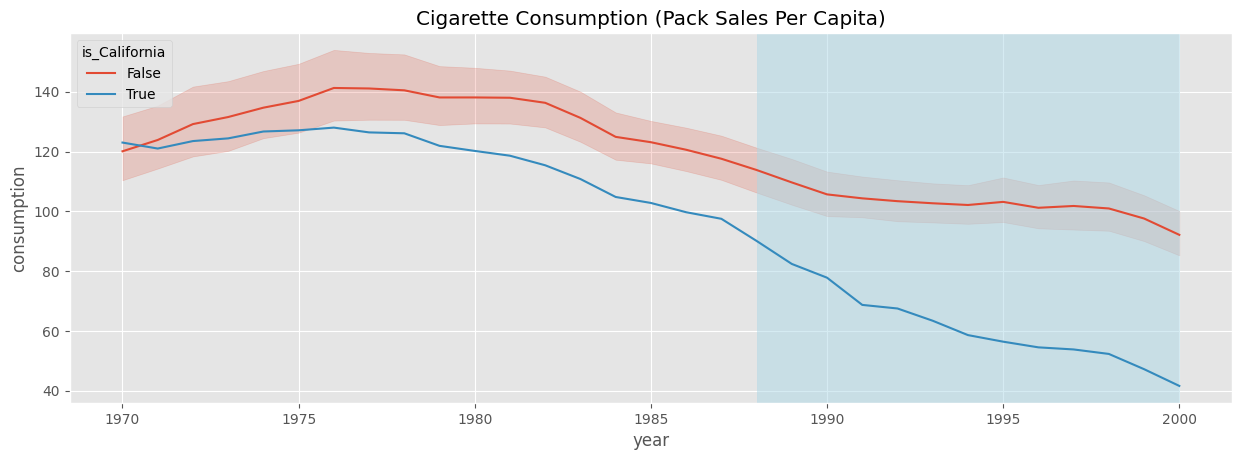

In [4]:
fig, ax = plt.subplots()
fig.set_figwidth(15)

sns.lineplot(x="year", y="consumption", hue="is_California", data=melt_df, ax=ax)

ax.axvspan(1988, 2000, alpha=0.5, color="lightblue")

plt.title("Cigarette Consumption (Pack Sales Per Capita)")
plt.show()

## Synthetic difference in differences
- In the following, we will try to reproduce the original paper using the method of pysynthdid.

In [5]:
sdid = SynthDID(df, PRE_TEREM, POST_TEREM, TREATMENT)
sdid.fit(zeta_type="base")

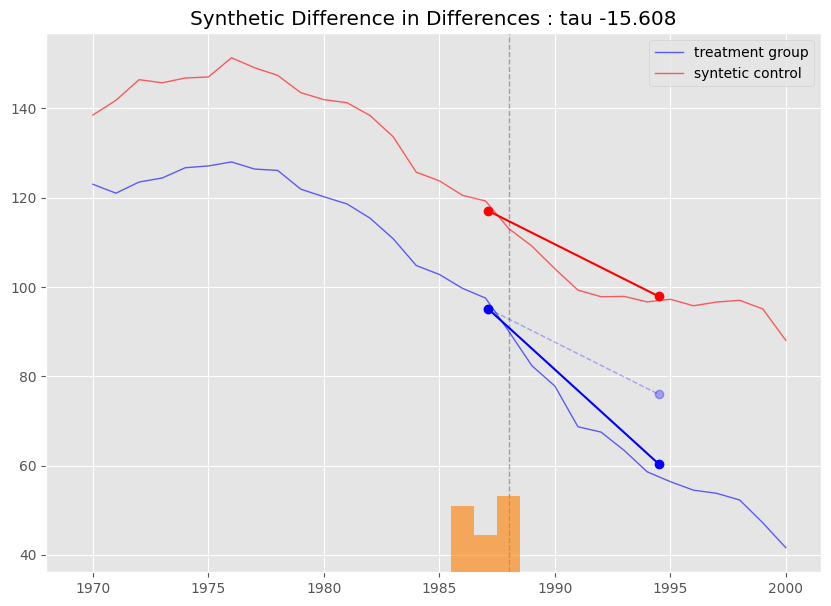

In [6]:
sdid.plot(model="sdid")

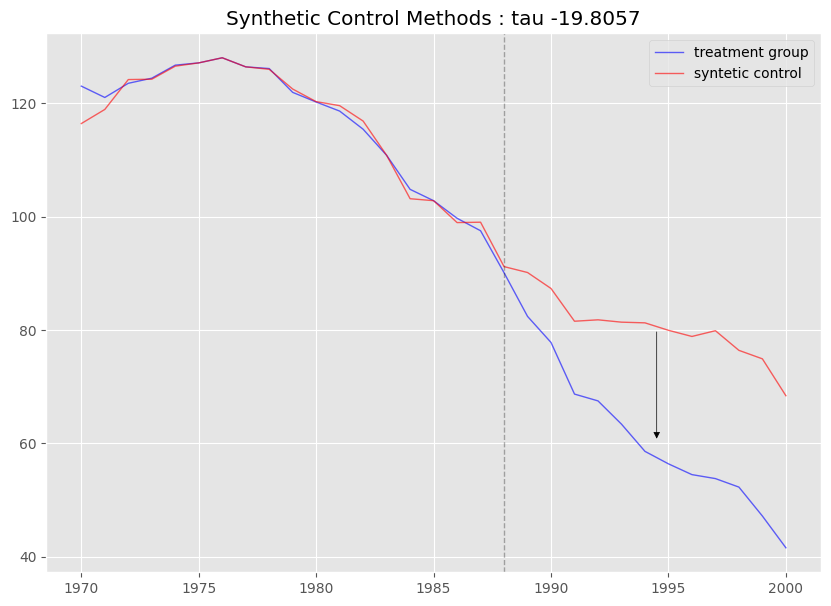

In [7]:
sdid.plot(model="sc")

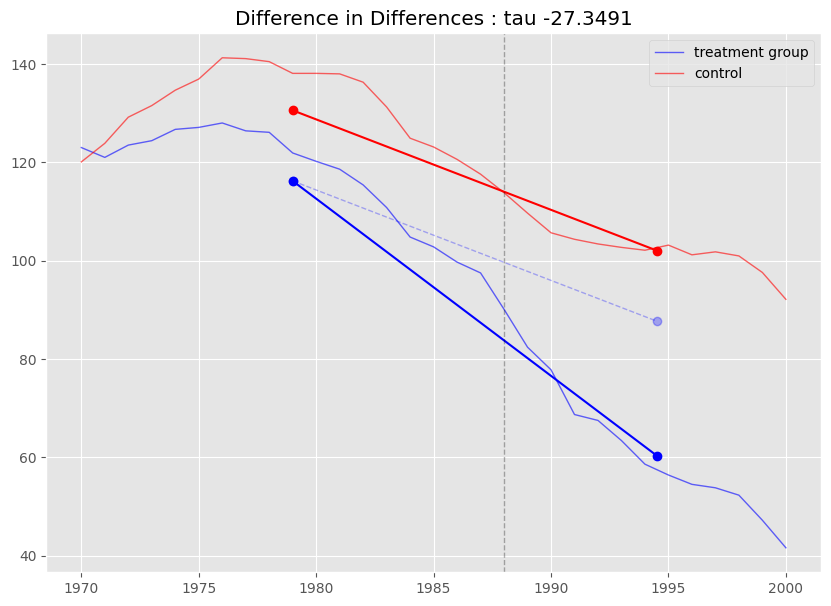

In [8]:
sdid.plot(model="did")

## Confirmation of differences in estimated parameters 

<img src="fig/original_lambda.png" style="width:500px;">

<img src="fig/original_omega.png" style="width:300px;">
original paper 7.2 Unit/time weights for California

### (1) : omega
- In both ADH(Classic) SC and SDID, omega is able to confirm that the results were mostly consistent with the original paper.
- For omega in SDID, the weight for `Arkansasu` is 0.03 in the original paper, but is estimated to be 0 in this package pysyndid.
- The weight table in the original paper exceeds 1 when all the weights are added together, so it is probably a typo.
- In the R package, the weight of `Arkansasu` is estimated to be 0 as in this package pysyndid.

<img src="fig/r_synthdid_result.png" style="width:400px;">

- R pkg : [synthdid](https://github.com/synth-inference/synthdid)
- script > notebook/Rsythdid.Rmd

In [9]:
test_omega = pd.read_csv("../test/test_data/omega_CalifolinaSmoking.csv")

In [10]:
hat_omega = sdid.estimated_params(model="sc")

In [11]:
hat_omega_sdid, hat_lambda_sdid, = sdid.estimated_params()

In [12]:
omega_result = pd.merge(
            test_omega, hat_omega_sdid, left_on="state", right_on="features", how="left"
        )
omega_result = pd.merge(
            omega_result, hat_omega, left_on="features", right_on="features", how="left"
        )

In [13]:
omega_result =  omega_result.rename(
    columns={
        "omega_ADH": "original_sc",
        "omega_sdid": "original_sdid",
        "sdid_weight": "pysdid_sdid",
        "sc_weight": "pysdid_sc",
    }
).drop("features",axis=1)

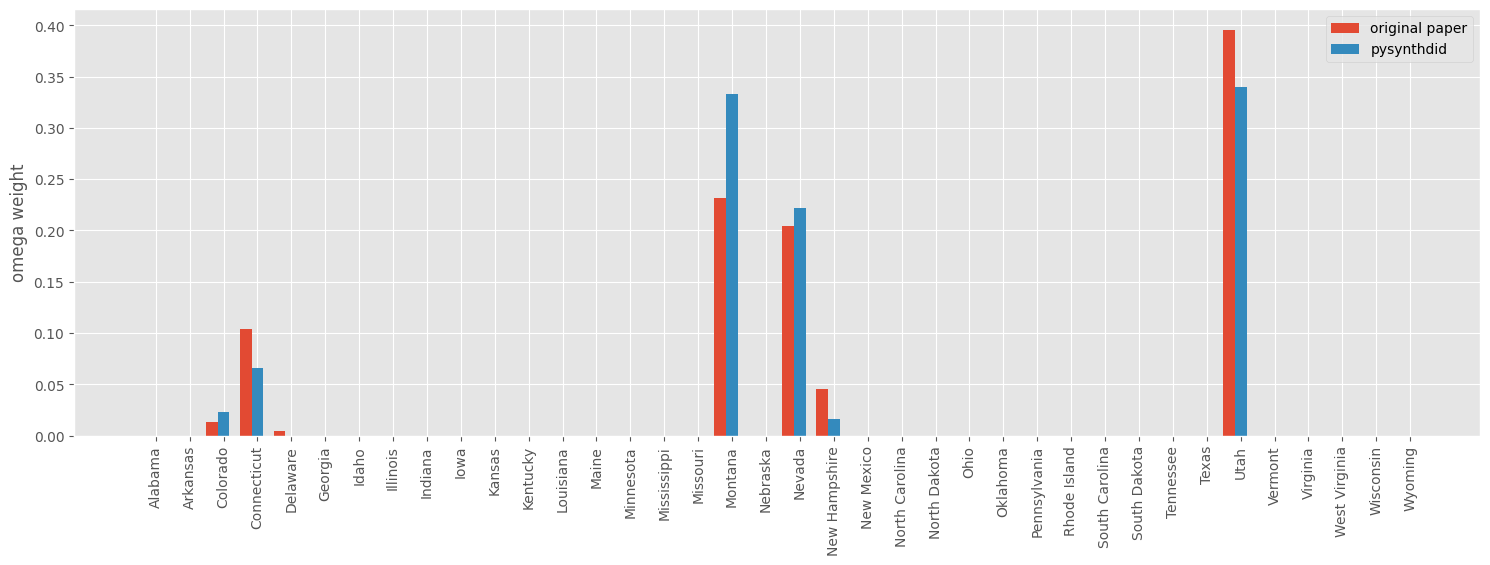

In [14]:
fig = plt.figure()
fig.set_figwidth(15)
ax = fig.add_subplot(1, 1, 1)
width = 0.35
ind = np.arange(len(omega_result))
ax.bar(ind - width, omega_result["original_sc"], width, label="original paper")
ax.bar(ind, omega_result["pysdid_sc"], width, label="pysynthdid")

ax.set_xticks(ind)
ax.set_xticklabels(omega_result["state"].values)
ax.legend()
ax.set_ylabel("omega weight")

fig.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [15]:
print("Synth. Control :")
error_sc_omega = np.sqrt(omega_result.eval("original_sc - pysdid_sc") ** 2).sum()
print("error form original paper: ", error_sc_omega)
adh_corr, _p = spearmanr(omega_result["original_sc"], omega_result["pysdid_sc"])
print("corr. with original paper : ", adh_corr)

Synth. Control :
error form original paper:  0.256
corr. with original paper :  0.9382720349657347


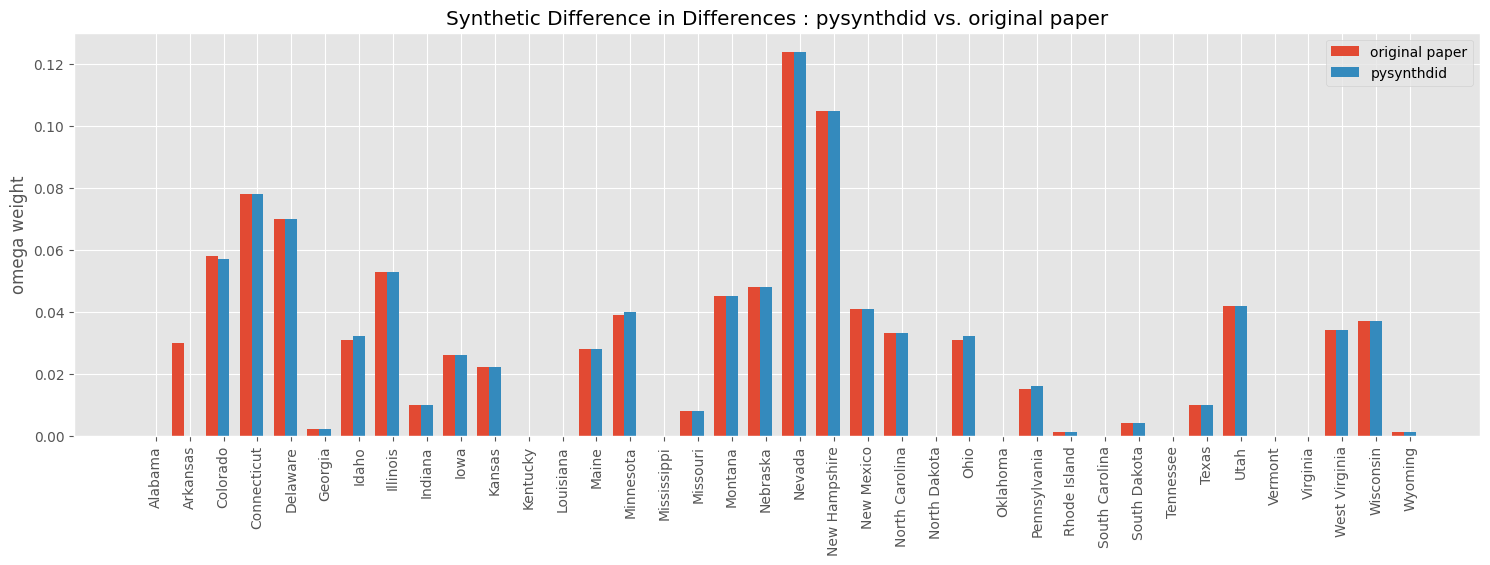

In [16]:
fig = plt.figure()
fig.set_figwidth(15)
ax = fig.add_subplot(1, 1, 1)
width = 0.35
ind = np.arange(len(omega_result))
ax.bar(ind - width, omega_result["original_sdid"], width, label="original paper")
ax.bar(ind, omega_result["pysdid_sdid"], width, label="pysynthdid")

ax.set_xticks(ind)
ax.set_xticklabels(omega_result["state"].values)
ax.legend()
ax.set_ylabel("omega weight")
ax.set_title("Synthetic Difference in Differences : pysynthdid vs. original paper")
fig.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [17]:
print(f"Synth. Diff in Diff (zeta= {sdid.zeta} ):")
error_sdid_omega = np.sqrt(omega_result.eval("original_sdid- pysdid_sdid") ** 2).sum()
print("error form original paper: ",  error_sdid_omega)
sdid_corr, _p = spearmanr(omega_result["original_sdid"], omega_result["pysdid_sdid"])
print("corr. with original paper : ",  sdid_corr)

Synth. Diff in Diff (zeta= 10.218754521078738 ):
error form original paper:  0.035
corr. with original paper :  0.9698709683648776


In [18]:
omega_result.drop("state", axis=1).sum()

original_sc      0.998
original_sdid    1.026
pysdid_sdid      0.999
pysdid_sc        1.000
dtype: float64

### (2) : lambda
- ` lambda` is almost identical to the original paper

In [19]:
test_lambda = pd.read_csv("../test/test_data/lambda_CalifolinaSmoking.csv")

In [20]:
lambda_result = pd.merge(
            test_lambda, hat_lambda_sdid, left_on="year", right_on="time", how="left"
        )
del lambda_result["time"]

In [21]:
cm = sns.light_palette("green", as_cmap=True)
lambda_result.rename(
    columns={"lambda_sdid": "original paper", "sdid_weight": "pysynthdid"}
).style.background_gradient(cmap=cm,subset=['original paper','pysynthdid'])

,year,original paper,pysynthdid
0,1970,0.000000,0.000000
1,1971,0.000000,0.000000
2,1972,0.000000,0.000000
3,1973,0.000000,0.000000
4,1974,0.000000,0.000000
5,1975,0.000000,0.000000
6,1976,0.000000,0.000000
7,1977,0.000000,0.000000
8,1978,0.000000,0.000000
9,1979,0.000000,0.000000


## AA test
- The following figure is a reproduction of the following slide presentation by Susan Athey (Stanford University)
- slide: Susan Athey "**Synthetic Differences in Differences.**" https://www.aeaweb.org/conference/2020/preliminary/powerpoint/fnQr9QDs
- This was estimated using the 8 years prior to the California intervention as a pseudo-intervention period (so `the estimated potential outcome = acutal outcome` should hold).
- As shown in the following two charts, the results are generally consistent with those in the slide.

In [22]:
PRE_TEREM2 = [1970, 1979]
POST_TEREM2 = [1980, 1988]
sdid_c = SynthDID(df, PRE_TEREM2, POST_TEREM2,  ["California"])
sdid_nh = SynthDID(df, PRE_TEREM2, POST_TEREM2, ["New Hampshire"])

In [23]:
sdid_c.fit()
sdid_nh.fit()

<img src="fig/california.png">

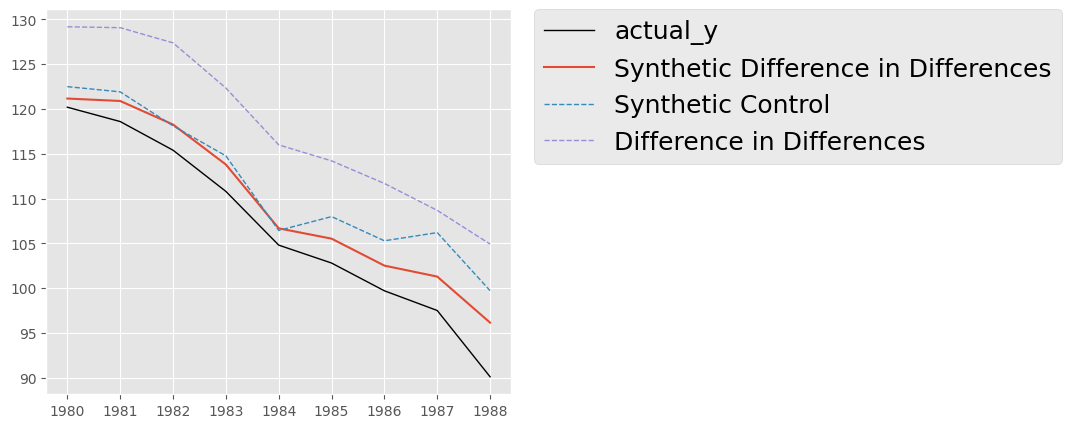

state : California


In [24]:
sdid_c.comparison_plot(figsize=(6,5))
print("state : California")


<img src="fig/NewHampshire.png">

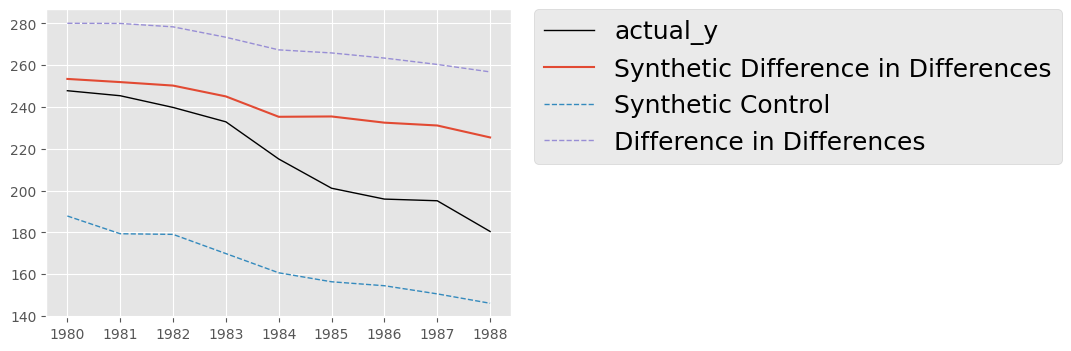

state : New Hampshire


In [25]:
sdid_nh.comparison_plot(figsize=(6,4))
print("state : New Hampshire")

- The above work was applied to all the states.
- As shown in the following chart, the proposed method, `Synthetic Difference in Differences (pysynthdid)`, shows better results than the classical `Syntetic Control Methods`.

In [26]:
state_list = df.columns

result_rmse_list = []
state_tau_dict = {}

for _state in tqdm(state_list):
    _sdid = SynthDID(df, PRE_TEREM2, POST_TEREM2, [_state])
    _sdid.fit()

    _outcome = pd.DataFrame({"actual_y": _sdid.target_y()})

    _outcome["did"] = _sdid.did_potentical_outcome()
    _outcome["sc"] = _sdid.sc_potentical_outcome()
    _outcome["sdid"] = _sdid.sdid_potentical_outcome()
    _outcome = _outcome.loc[POST_TEREM2[0] : POST_TEREM2[1]]

    _rmse = np.sqrt((_outcome.mean() - _outcome.mean()["actual_y"]) ** 2)
    _rmse = pd.DataFrame(_rmse).T[["did", "sc", "sdid"]]
    _rmse.index = [_state]

    result_rmse_list.append(_rmse)
    
    state_tau_dict[_state] = {
        "did": _sdid.hat_tau(model="did"),
        "sc": _sdid.hat_tau(model="sc"),
        "sdid": _sdid.hat_tau(model="sdid")
    }

100%|██████████| 39/39 [02:19<00:00,  3.59s/it]


In [27]:
result_rmse = pd.concat(result_rmse_list)

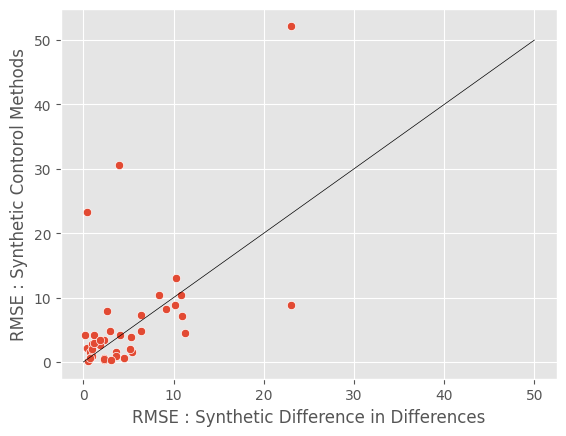

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
_x = np.linspace(0, 50, 30)
_y = _x
sns.scatterplot(data=result_rmse, x="sdid", y="sc", ax = ax)
ax.plot(_x, _y, color='black',  linestyle='solid',linewidth = 0.5)
ax.set_xlabel("RMSE : Synthetic Difference in Differences")
ax.set_ylabel("RMSE : Synthetic Contorol Methods")
#ax.set_xlim(0, 25)
#ax.set_ylim(0, 55)
plt.show()

In [29]:
result_rmse.mean()

did     9.436689
sc      6.396863
sdid    4.990856
dtype: float64

In [30]:
# Confirmation calculation
(pd.DataFrame(state_tau_dict).T**2).apply(np.sqrt).mean()

did     9.436689
sc      6.396863
sdid    4.990847
dtype: float64

In [31]:
print("Done")

Done
